# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [12]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1);

In [13]:
sum(a)

4.998670837481011e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [14]:
@time sum(a)

  0.004732 seconds (1 allocation: 16 bytes)


4.998670837481011e6

In [15]:
@time sum(a)

  0.004825 seconds (1 allocation: 16 bytes)


4.998670837481011e6

In [16]:
@time sum(a)

  0.005512 seconds (1 allocation: 16 bytes)


4.998670837481011e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [4]:
# using Pkg
# Pkg.add("BenchmarkTools")

   Updating registry at `~/.juliapro/JuliaPro_v1.4.1-1/registries/JuliaPro`
  Resolving package versions...
  Installed BenchmarkTools ─ v0.5.0
   Updating `~/.juliapro/JuliaPro_v1.4.1-1/environments/v1.4/Project.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
   Updating `~/.juliapro/JuliaPro_v1.4.1-1/environments/v1.4/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0


In [17]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [18]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [19]:
c_sum(a)

4.9986708374811495e6

In [20]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [13]:
c_sum(a) - sum(a)

-4.4051557779312134e-7

In [14]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

In [15]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [24]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.883 ms (0.00% GC)
  median time:      12.497 ms (0.00% GC)
  mean time:        12.491 ms (0.00% GC)
  maximum time:     13.650 ms (0.00% GC)
  --------------
  samples:          400
  evals/sample:     1

In [25]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 11.882898 msec


In [26]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 11.8829

In [27]:
using Plots
gr()

Plots.GRBackend()

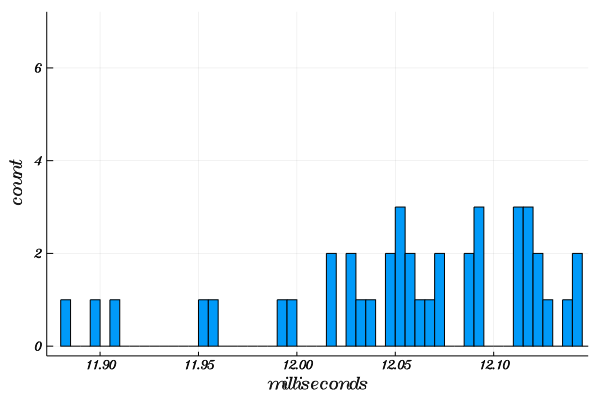

In [28]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")
# # 2. C with -ffast-math

In [29]:
# If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [30]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.321 ms (0.00% GC)
  median time:      4.749 ms (0.00% GC)
  mean time:        4.828 ms (0.00% GC)
  maximum time:     6.511 ms (0.00% GC)
  --------------
  samples:          1033
  evals/sample:     1

In [31]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.321125

# 3. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [44]:
Pkg.add("PkgId")

Pkg.Types.PkgError: The following package names could not be resolved:
 * PkgId (not found in project, manifest or registry)


In [45]:
#using Pkg
#Pkg.build("PyCall")
#ENV["PYTHON"]="" <------------ Execute from terminal! Or just google the problem you are getting
#Pkg.build("PyCall")
using PyCall

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1260


In [46]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [47]:
pysum(a)

4.9986708374811495e6

In [48]:
pysum(a) ≈ sum(a)

true

In [49]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.519 s (0.00% GC)
  median time:      1.550 s (0.00% GC)
  mean time:        1.547 s (0.00% GC)
  maximum time:     1.571 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [50]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "Julia hand-written simd" => 4.25797
  "C"                       => 11.8829
  "Julia hand-written"      => 12.156
  "Julia built-in"          => 4.10985
  "Python built-in"         => 1518.71
  "C -ffast-math"           => 4.32113

# 4. Python: `numpy`

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [2]:
# using Pkg; Pkg.add("Conda")
using Conda

   Updating registry at `~/.juliapro/JuliaPro_v1.4.1-1/registries/JuliaPro`
  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.1-1/environments/v1.4/Project.toml`
  [8f4d0f93] + Conda v1.4.1
   Updating `~/.juliapro/JuliaPro_v1.4.1-1/environments/v1.4/Manifest.toml`
 [no changes]


In [3]:
 Conda.add("numpy")

┌ Info: Downloading miniconda installer ...
└ @ Conda /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/packages/Conda/3rPhK/src/Conda.jl:156
┌ Info: Installing miniconda ...
└ @ Conda /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/packages/Conda/3rPhK/src/Conda.jl:166


PREFIX=/Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/Conda_env
Unpacking payload ...


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/Conda_env

  added / updated specs:
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37hb5b8e2f_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h1de35cc_0
    - conda==4.8.2=py37_0
    - cryptography==2.8=py37ha12b0ac_0
    - idna==2.8=py37_0
    - libcxx==4.0.1=hcfea43d_1
    - libcxxabi==4.0.1=hcfea43d_1
    - libedit==3.1.20181209=hb402a30_0
    - libffi==3.2.1=h475c297_4
    - ncurses==6.2=h0a44026_0
    - openssl==1.1.1d=h1de35cc_4
    - pip==20.0.2=py37_1
    - pycosat==0.6.3=py37h1de35cc_0
    - pycparser==2.19=py37_0
    - pyopenssl==19.1.0=py37_0
    - pysocks==1.7.1=py37_0
    - python.app==2=py37_10
    - python==3.7.6=h359304d_2
    - readline==7.0=h1de35cc_5
    - requests==2.22.0=py37_1
    - ruamel_yaml==0.15.87=py37h1de35cc_0
    - setuptools==45.2.0

┌ Info: Running `conda config --add channels defaults --file /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/Conda_env/condarc-julia.yml --force` in root environment
└ @ Conda /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/packages/Conda/3rPhK/src/Conda.jl:113
┌ Info: Running `conda update -y conda` in root environment
└ @ Conda /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/packages/Conda/3rPhK/src/Conda.jl:113


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/Conda_env

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |           py37_0         155 KB
    conda-4.8.3                |           py37_0         2.8 MB
    conda-package-handling-1.6.1|   py37h1de35cc_0         1.3 MB
    cryptography-2.9.2         |   py37ha12b0ac_0         547 KB
    idna-2.9                   |             py_1          49 KB
    libffi-3.2.1               |       h0a44026_6          39 KB
    ncurses-6.2                |       h0a44026_1         749 KB
    openssl-1.1.1g             |       h1de35cc_0         2.2 MB
    pip-20.0.2                 |           py37_3         1.7 MB
    pycparser-2.20             |             py_0          92 KB
    requests-2.23.0       

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/packages/Conda/3rPhK/src/Conda.jl:113


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/arizalex/.juliapro/JuliaPro_v1.4.1-1/Conda_env

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    intel-openmp-2019.4        |              233         887 KB
    libgfortran-3.0.1          |       h93005f0_2         426 KB
    mkl-2019.4                 |              233       101.9 MB
    mkl-service-2.3.0          |   py37hfbe908c_0         201 KB
    mkl_fft-1.0.15             |   py37h5e564d8_0         136 KB
    mkl_random-1.1.0           |   py37ha771720_0         275 KB
    numpy-1.18.1               |   py37h7241aed_0           5 KB
    numpy-base-1.18.1          |   py37h6575580_1         3.9 MB
    ------------------------------------------------------------
                           

In [51]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[51]:1
└ @ Core In[51]:1


BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     4.355 ms (0.00% GC)
  median time:      4.491 ms (0.00% GC)
  mean time:        4.551 ms (0.00% GC)
  maximum time:     6.853 ms (0.00% GC)
  --------------
  samples:          1098
  evals/sample:     1

In [52]:
numpy_sum(a)

4.998670837481021e6

In [53]:
numpy_sum(a) ≈ sum(a)

true

In [54]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "Julia hand-written simd" => 4.25797
  "C"                       => 11.8829
  "Julia hand-written"      => 12.156
  "Python numpy"            => 4.35539
  "Julia built-in"          => 4.10985
  "Python built-in"         => 1518.71
  "C -ffast-math"           => 4.32113

# 5. Python, hand-written

In [55]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x15301d5f0>

In [56]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     2.028 s (0.00% GC)
  median time:      2.052 s (0.00% GC)
  mean time:        2.049 s (0.00% GC)
  maximum time:     2.067 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [57]:
sum_py(a)

4.9986708374811495e6

In [58]:
sum_py(a) ≈ sum(a)

true

In [59]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 4.25797
  "C"                       => 11.8829
  "Julia hand-written"      => 12.156
  "Python numpy"            => 4.35539
  "Python hand-written"     => 2027.57
  "Julia built-in"          => 4.10985
  "Python built-in"         => 1518.71
  "C -ffast-math"           => 4.32113

# 6. Julia (built-in)

## Written directly in Julia, not in C!

In [21]:
@which sum(a)

sum(a::AbstractArray; dims) in Base at reducedim.jl:652

In [22]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.110 ms (0.00% GC)
  median time:      4.632 ms (0.00% GC)
  mean time:        4.724 ms (0.00% GC)
  maximum time:     6.177 ms (0.00% GC)
  --------------
  samples:          1056
  evals/sample:     1

In [33]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"              => 11.8829
  "Julia built-in" => 4.10985
  "C -ffast-math"  => 4.32113

# 7. Julia (hand-written)

In [34]:
function mysum(A)
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [35]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.156 ms (0.00% GC)
  median time:      12.796 ms (0.00% GC)
  mean time:        12.807 ms (0.00% GC)
  maximum time:     14.553 ms (0.00% GC)
  --------------
  samples:          390
  evals/sample:     1

In [36]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                  => 11.8829
  "Julia hand-written" => 12.156
  "Julia built-in"     => 4.10985
  "C -ffast-math"      => 4.32113

# 8. Julia (hand-written w. simd)

In [37]:
function mysum_simd(A)
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [38]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.258 ms (0.00% GC)
  median time:      4.708 ms (0.00% GC)
  mean time:        4.777 ms (0.00% GC)
  maximum time:     5.797 ms (0.00% GC)
  --------------
  samples:          1044
  evals/sample:     1

In [39]:
mysum_simd(a)

4.998670837480987e6

In [40]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "Julia hand-written simd" => 4.25797
  "C"                       => 11.8829
  "Julia hand-written"      => 12.156
  "Julia built-in"          => 4.10985
  "C -ffast-math"           => 4.32113

# Summary

In [60]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............4.1
Julia hand-written simd.....4.3
C -ffast-math...............4.3
Python numpy................4.4
C..........................11.9
Julia hand-written.........12.2
Python built-in..........1518.7
Python hand-written......2027.6
